In [35]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.circuit import Parameter, ParameterVector
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

#### Declare paramters

In [36]:
import os
#Regimes
regime = 10
initial_state=(1 / np.sqrt(2))*(Zero ^ Zero) + (1 / np.sqrt(2))*(One ^ One)#Zero ^ One#
state = "bell"

num_sites = 2
if regime == 1:
    base_path = f"figures/2-site/regime{regime}_{state}/"
    eps = 0
    t = 1
    delta = 1
elif regime == 2:
    base_path = f"figures/2-site/regime{regime}_{state}/"
    eps = 0
    t = 2
    delta = 1
elif regime == 3:
    base_path = f"figures/2-site/regime{regime}_{state}/"
    eps = 0
    t = 1
    delta = 2
else:
    base_path = f"figures/2-site/random_{state}/"
    eps = 10
    t = 0
    delta = 0


# Create folder if it doesn't exist
os.makedirs(base_path, exist_ok=True)

In [37]:
def compute_H(eps, t, delta, num_sites):

    H = 0
    H += eps * (I ^ I)
    H -= eps / 2 * (I ^ Z)
    H -= eps / 2 * (Z ^ I)
    H += (t + delta) / 2 * (X ^ X)
    H += (t - delta) / 2 * (Y ^ Y)

    # for i in range(num_sites):
    #     H += I ^ num_sites
    #     H += eps / 2 * ((I ^ num_sites) - ((I ^ (num_sites - i - 1)) ^ Z ^ (I ^ i)))
    #     if i < num_sites - 1:
    #         H += (t + delta) / 2 * ((I ^ (num_sites - i - 2)) ^ (X ^ X) ^ (I ^ i))
    #         H += (t - delta) / 2 * ((I ^ (num_sites - i - 2)) ^ (Y ^ Y) ^ (I ^ i))

    return H

# Parameterized hopping strengths
eps_param = Parameter("ε")
t_param = Parameter("t")
delta_param = Parameter("Δ")
H_param = compute_H(eps_param, t_param, delta_param, num_sites)

# Select specific tau and tau_d values
H = H_param.bind_parameters({eps_param: eps, t_param: t, delta_param: delta})

# Print Hamiltonian operators to confirm it's what we expect
H

SummedOp([PauliOp(Pauli('II'), coeff=10.0), PauliOp(Pauli('IZ'), coeff=-5.0), PauliOp(Pauli('ZI'), coeff=-5.0), PauliOp(Pauli('XX'), coeff=0.0), PauliOp(Pauli('YY'), coeff=0.0)], coeff=1.0, abelian=False)

### Import observables

In [43]:
#Number operator
from operators import n_op, p_op, cc_nb_op, corr_op, corr_dagger_op

n_is = n_op(num_sites)
cc_nb_is = [corr_op(num_sites,0,1)]
cc_dagger_nb_is = [corr_dagger_op(num_sites,0,0)]

cc_dagger_nb_is

[PauliSumOp(SparsePauliOp(['II'],
               coeffs=[0.+0.j]), coeff=1.0)]

### Classical simulation

In [39]:
#Parameters for simulation
times = np.linspace(0, 8 * np.pi, 200)

from functions import exact_time_evolution, exact_time_evolution_energy, exact_time_evolution_density

n_evo_matrix, n_var_matrix = exact_time_evolution(H, n_is, initial_state, times, num_sites)
cc_evo_matrix, cc_var_matrix = exact_time_evolution(H, cc_nb_is, initial_state, times, num_sites)
cc_dagger_evo_matrix, cc_dagger_var_matrix = exact_time_evolution(H, cc_dagger_nb_is, initial_state, times, num_sites)

p_values = np.linspace(0, 1, 100)
E_evo_full = np.zeros((len(p_values), len(times)))
for idx, p in enumerate(p_values):
    initial_state = p*(One ^ Zero) + (1-p)*(Zero ^ One)

    E_evo_vector, E_var_vector = exact_time_evolution_energy(
        H, initial_state, times, num_sites
    )
    # E_evo_vector has shape (num_t,)
    E_evo_full[idx, :] = E_evo_vector 

# p_values = np.linspace(0, 1, 100)
# rho_evo_full = np.zeros((len(p_values), len(times)))
# for idx, p in enumerate(p_values):
#     initial_state = p*(One ^ Zero) + (1-p)*(Zero ^ One)

#     rho_evo_vector, rho_var_vector = exact_time_evolution_density(
#         H, initial_state, times, num_sites
#     )
#     # E_evo_vector has shape (num_t,)
#     rho_evo_full[idx, :] = rho_evo_vector


100%|██████████| 200/200 [00:00<00:00, 719.05it/s]


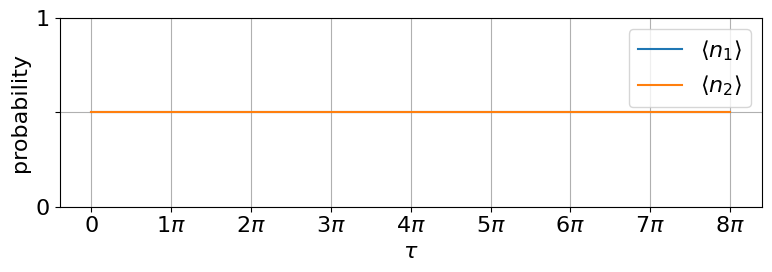

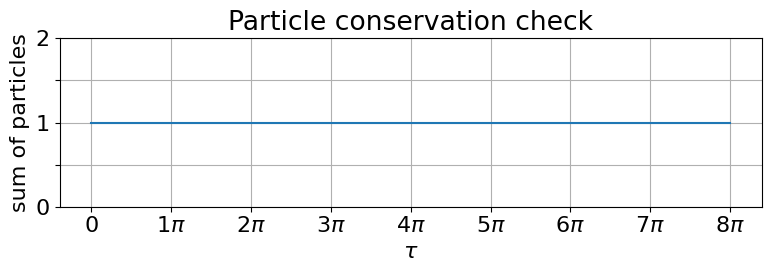

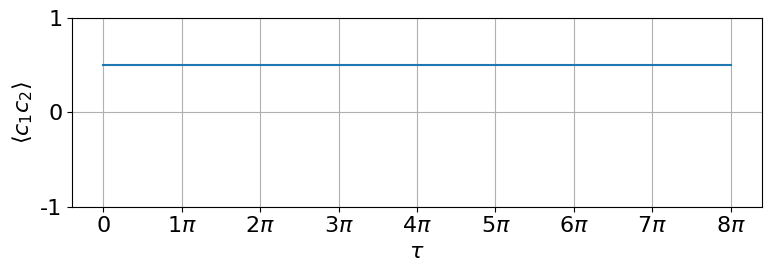

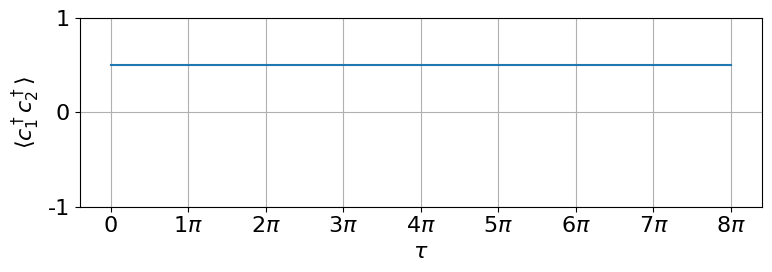

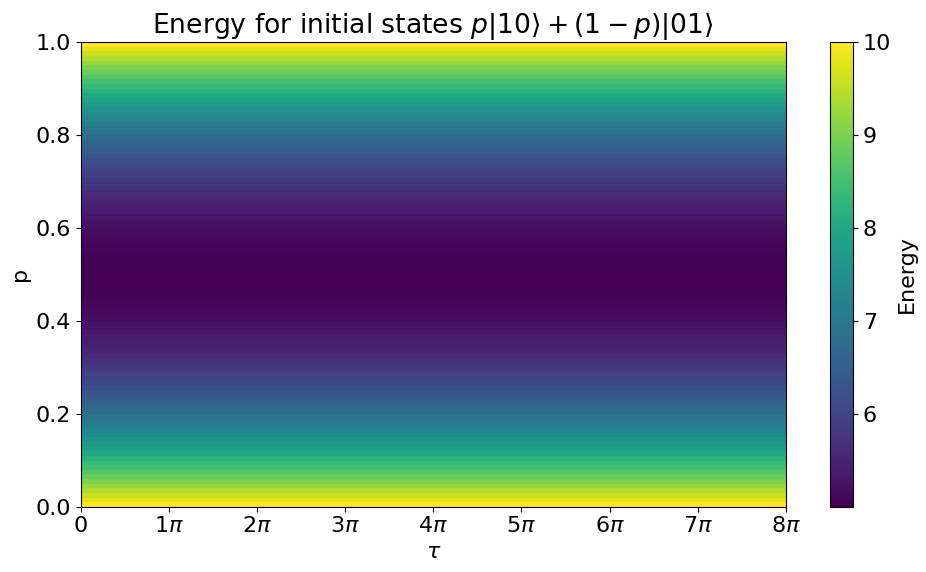

In [40]:
num_op_labels = [r"$\langle n_" + str(i+1) + "\\rangle$" for i in range(num_sites)]
xticks = np.linspace(0, 8*np.pi, 9)
xtick_labels = [r'${}\pi$'.format(i) if i != 0 else '0' for i in range(9)]

path = base_path + "2-site-prob.pdf"

plt.figure(figsize=(8, 3))
plt.plot(times, n_evo_matrix,)
plt.xlabel(r"$\tau$")
plt.ylabel("probability")
#plt.title("Probability of occupying a given site")
plt.grid()
plt.legend(num_op_labels)
plt.yticks([0, 0.5, 1], ['0','', '1'])
plt.xticks(xticks, xtick_labels)
plt.savefig(path)
plt.tight_layout()

path = base_path + "2-site-particle-count.pdf"

plt.figure(figsize=(8, 3))
plt.plot(times, np.sum(n_evo_matrix, axis=1))
plt.xlabel(r"$\tau$")
plt.ylabel("sum of particles")
plt.title("Particle conservation check")
plt.ylim([0, 2])
plt.yticks([0,0.5, 1, 1.5, 2], ['0','','1', '', '2'])
plt.xticks(xticks, xtick_labels)
plt.grid()
plt.tight_layout()
plt.savefig(path)

path = base_path + "2-site-corr_nb.pdf"

plt.figure(figsize=(8, 3))
plt.plot(times, np.sum(cc_evo_matrix, axis=1))
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\langle c_1 c_2 \rangle$")
plt.yticks([-1, 0, 1], ['-1','0', '1'])
plt.xticks(xticks, xtick_labels)
plt.grid()
plt.tight_layout()
plt.savefig(path)

path = base_path + "2-site-corr-dagger_nb.pdf"

plt.figure(figsize=(8, 3))
plt.plot(times, np.sum(cc_evo_matrix, axis=1))
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\langle c_1^\dagger c_2^\dagger \rangle$")
plt.yticks([-1, 0, 1], ['-1','0', '1'])
plt.xticks(xticks, xtick_labels)
plt.grid()
plt.tight_layout()
plt.savefig(path)

path = base_path + "2-site-energy.pdf"
plt.figure(figsize=(10, 6))
plt.imshow(
    E_evo_full,
    aspect='auto',
    extent=[times[0], times[-1], p_values[0], p_values[-1]],
    origin='lower',
    cmap='viridis'
)
plt.colorbar(label='Energy')
plt.title(r'Energy for initial states $p|10\rangle + (1-p)|01\rangle$')
plt.xlabel(r'$\tau$')
plt.xticks(xticks, xtick_labels)
plt.ylabel('p')
plt.tight_layout()

plt.show()

### Trotterization

In [41]:
import sys
sys.exit("Stopping here")
# Time evolution calculation using same parameters as the exact classical calculation
from functions import trotter_evolution

# Number of trotter steps
trotter_steps = 8

# Calculate each number operator's expectation value at each time point and store in a 2D array
n_evo_matrix_trot = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps)

# Plot the time evolution
path = base_path + "2-site-prob-trotter.pdf"

plt.figure(figsize=(10, 3))
plt.plot(times, n_evo_matrix_trot)
plt.xlabel("time")
plt.ylabel("probability")
plt.title(f"Probability of occupying a given site at m = {trotter_steps}")
plt.grid()
plt.legend(num_op_labels)
plt.tight_layout()
plt.savefig(path)
plt.show()

SystemExit: Stopping here

/home/oscartq/miniconda3/envs/article_mzm/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Trotter error

In [ ]:
# Number of trotter steps
trotter_steps_1 = 10

# Calculate each number operator's expectation value at each time point
evo_matrix_trot_1 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_1)

# Number of trotter steps
trotter_steps_2 = 20
# Calculate each number operator's expectation value at each time point
evo_matrix_trot_2 = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_2)

 64%|██████▍   | 129/200 [00:09<00:05, 13.04it/s]


KeyboardInterrupt: 

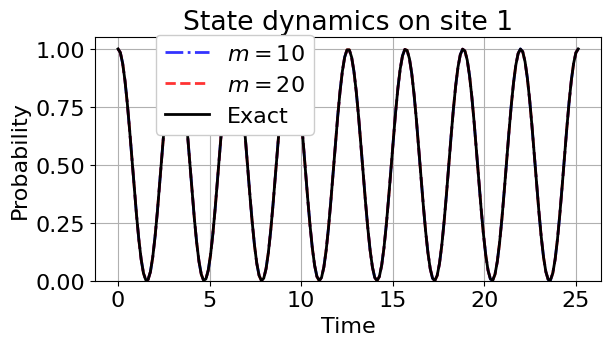

In [ ]:
# Plot state dynamics over one particular site
site = 0
path = base_path + "2-site-state_dynm_site1.pdf"

plt.figure(figsize=(6.25, 3.75))
plt.plot(
    times,
    evo_matrix_trot_1[:, site],
    "b-.",
    linewidth=2,
    label=rf"$m={trotter_steps_1}$",
    markerfacecolor="royalblue",
    alpha=0.8,
)
plt.plot(
    times,
    evo_matrix_trot_2[:, site],
    "r--",
    linewidth=2,
    label=rf"$m={trotter_steps_2}$",
    markerfacecolor="salmon",
    alpha=0.8,
)
plt.plot(
    times, n_evo_matrix[:, site], "k-", linewidth=2, label="Exact", markerfacecolor="grey"
)
plt.xlabel("Time")
plt.ylabel("Probability")
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc=(0.12, 0.6), framealpha=1)
plt.tight_layout()
plt.title("State dynamics on site " + str(site+1))
plt.tight_layout()
plt.savefig(path)
plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:09<00:00,  4.54s/it]


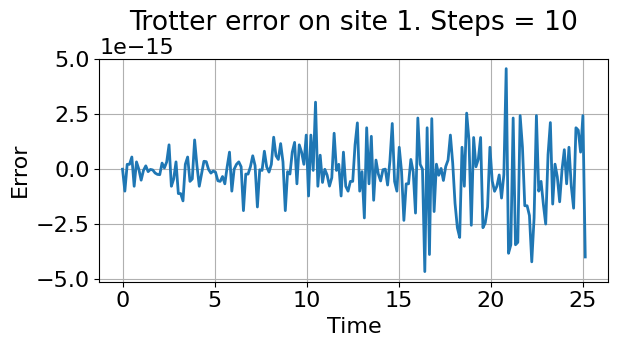

In [ ]:
# Number of trotter steps
trotter_steps_error = 10
path = base_path + "2-site-trotter_error_site1.pdf"

# Calculate each number operator's expectation value at each time point
evo_matrix_trot_error = trotter_evolution(H, n_is, initial_state, times, num_sites, trotter_steps_error)

# Plot state dynamics over one particular site
site = 0

plt.figure(figsize=(6.25, 3.75))
plt.plot(
    times,
    n_evo_matrix[:, site]-evo_matrix_trot_error[:, site],
    linewidth=2
)

plt.xlabel("Time")
plt.ylabel("Error")
plt.grid()
plt.title("Trotter error on site " + str(site+1) + f". Steps = {trotter_steps_error}")
plt.tight_layout()
plt.savefig(path)
plt.show()

### Generate circuit diagram

In [ ]:
from qiskit.opflow import PauliTrotterEvolution

def convert_U_trot_to_qc(U_trot):

    qc_trot = PauliTrotterEvolution().convert(U_trot)
    return (
        qc_trot.to_circuit().decompose()#.decompose()
    )  # add decompose methods so gates are not abstracted unitary blocks

In [ ]:
from functions import compute_U_trot
H = H_param.bind_parameters({eps_param: 0, t_param: 1, delta_param: 1})
U1 = compute_U_trot(H, np.pi, 1)
qc = convert_U_trot_to_qc(U1)

latex_code = qc.draw("latex_source")
#print(latex_code)
with open("circuits/2-site-circuit.tex", "w") as f:
    f.write(latex_code)


TypeError: Trotterization converters can only convert SummedOp or PauliSumOp.